### This notebook provides the Deep RNNs sources code for our paper "Localized Weather Prediction using Kolmogorov-Arnold Networks and Deep RNNs"

In [2]:
# pip install 

In [931]:
# import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset,TensorDataset
# from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
# from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [932]:
os.getcwd()

'/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Temperature'

**Data Importation and Information**

In [933]:
# data for Abidjan
Abj_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
# data for Kigali
Kgl_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks//data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})

# print(df.info())
# df.describe(),data_.describe()
# df.head(4) 

/tmp/ipykernel_1914949/3409575691.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Abj_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
/tmp/ipykernel_1914949/3409575691.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Kgl_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks//data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


In [934]:
##### No missing for both datasets ###
# Abj_dt.isna().sum()
# Kgl_dt.isnull().sum()
Abj_dt.columns


Index(['datetime', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS'],
      dtype='object')

In [935]:
#Rename Columns
col_name_map = {
    "ALLSKY_SFC_SW_DWN": "ASWD",
    "CLRSKY_SFC_SW_DWN":"CSWD","ALLSKY_SFC_LW_DWN":"ALWD","PRECTOTCORR":"PREC"
}
# new_colnames=['datetime', 'ASWD', 'CSWD',
#        'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
#        'PREC', 'PS']
# Rename the columns for both datasets
Abj_dt=Abj_dt.rename(columns=col_name_map)
Kgl_dt=Kgl_dt.rename(columns=col_name_map)



In [936]:
print(Abj_dt.info())
print(Kgl_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5114 non-null   datetime64[ns]
 1   ASWD      5114 non-null   float64       
 2   CSWD      5114 non-null   float64       
 3   ALWD      5114 non-null   float64       
 4   T2M       5114 non-null   float64       
 5   T2MDEW    5114 non-null   float64       
 6   T2MWET    5114 non-null   float64       
 7   QV2M      5114 non-null   float64       
 8   RH2M      5114 non-null   float64       
 9   PREC      5114 non-null   float64       
 10  PS        5114 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 439.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5114 non-null 

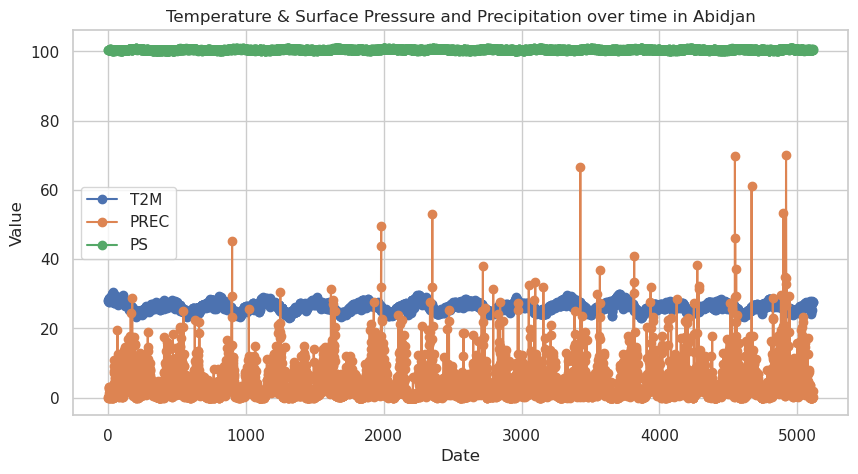

In [937]:
import pandas as pd
import matplotlib.pyplot as plt

# Select specific variables to plot
columns_to_plot = ['T2M', 'PREC','PS']

# Plot
Abj_dt[columns_to_plot].plot(figsize=(10, 5), marker='o')
plt.title('Temperature & Surface Pressure and Precipitation over time in Abidjan')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid(visible=True)
plt.show()


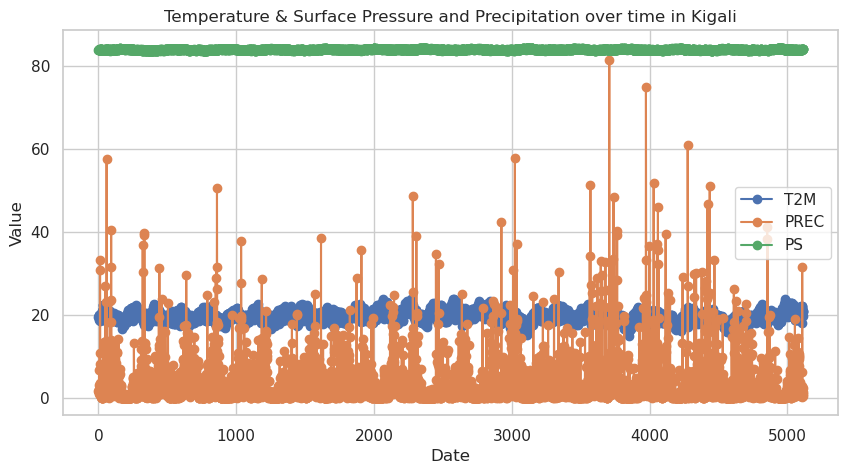

In [938]:
# Plot
Kgl_dt[columns_to_plot].plot(figsize=(10, 5), marker='o')
plt.title('Temperature & Surface Pressure and Precipitation over time in Kigali')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid(visible=True)
plt.show()

In [939]:
# # Plot
# df.plot(x='Date', y=columns_to_plot, figsize=(10, 5), marker='o')
# plt.title('Temperature & Humidity Over Time')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend(columns_to_plot)
# plt.grid()
# plt.show()

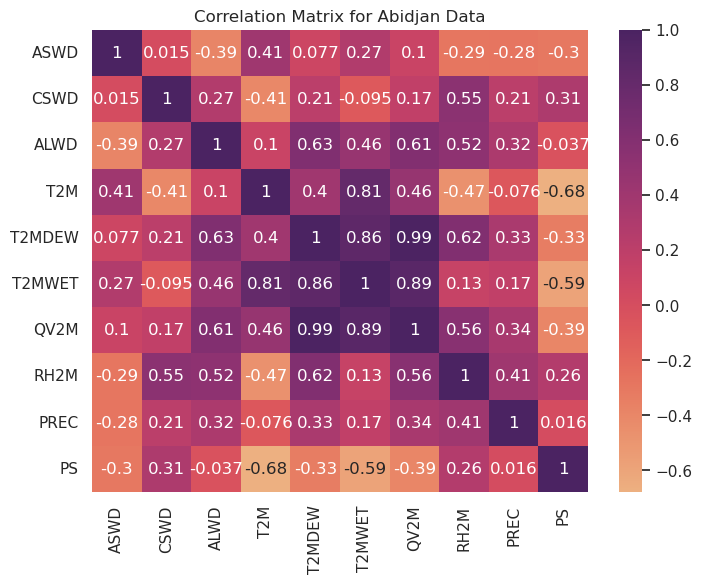

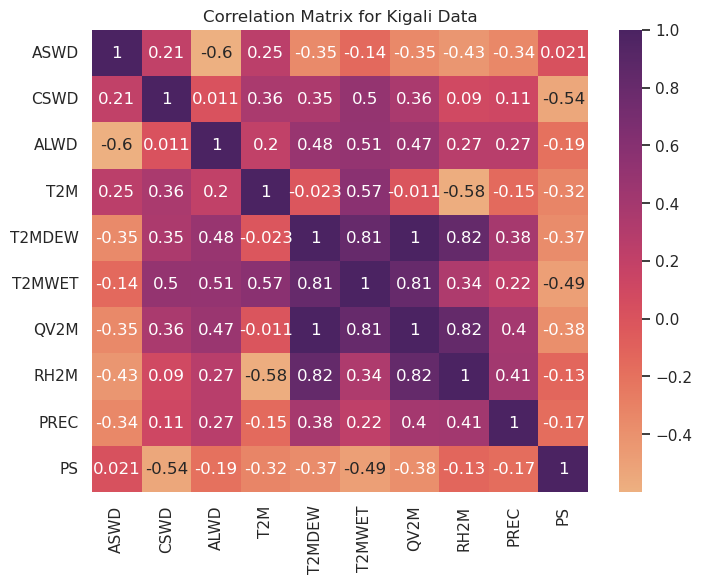

In [940]:
# df.columns,df_.columns
def displayHeatMap(dim1, dim2, title, df):
    fig=plt.figure(figsize=(dim1,dim2))
    plt.title(title)
    sns.heatmap(df, annot= True, cmap='flare')
# Define correlation matrix for both data
corr_Abj= Abj_dt.iloc[:,1:].corr()
corr_Kgl= Kgl_dt.iloc[:,1:].corr()
# Display the heatmap
displayHeatMap(8, 6,"Correlation Matrix for Abidjan Data",corr_Abj)
displayHeatMap(8, 6,"Correlation Matrix for Kigali Data",corr_Kgl)

In [941]:
Abj_dt=Abj_dt.set_index("datetime")
Kgl_dt=Kgl_dt.set_index("datetime")

In [942]:
# Abj_dt.columns

**Variable ploting**

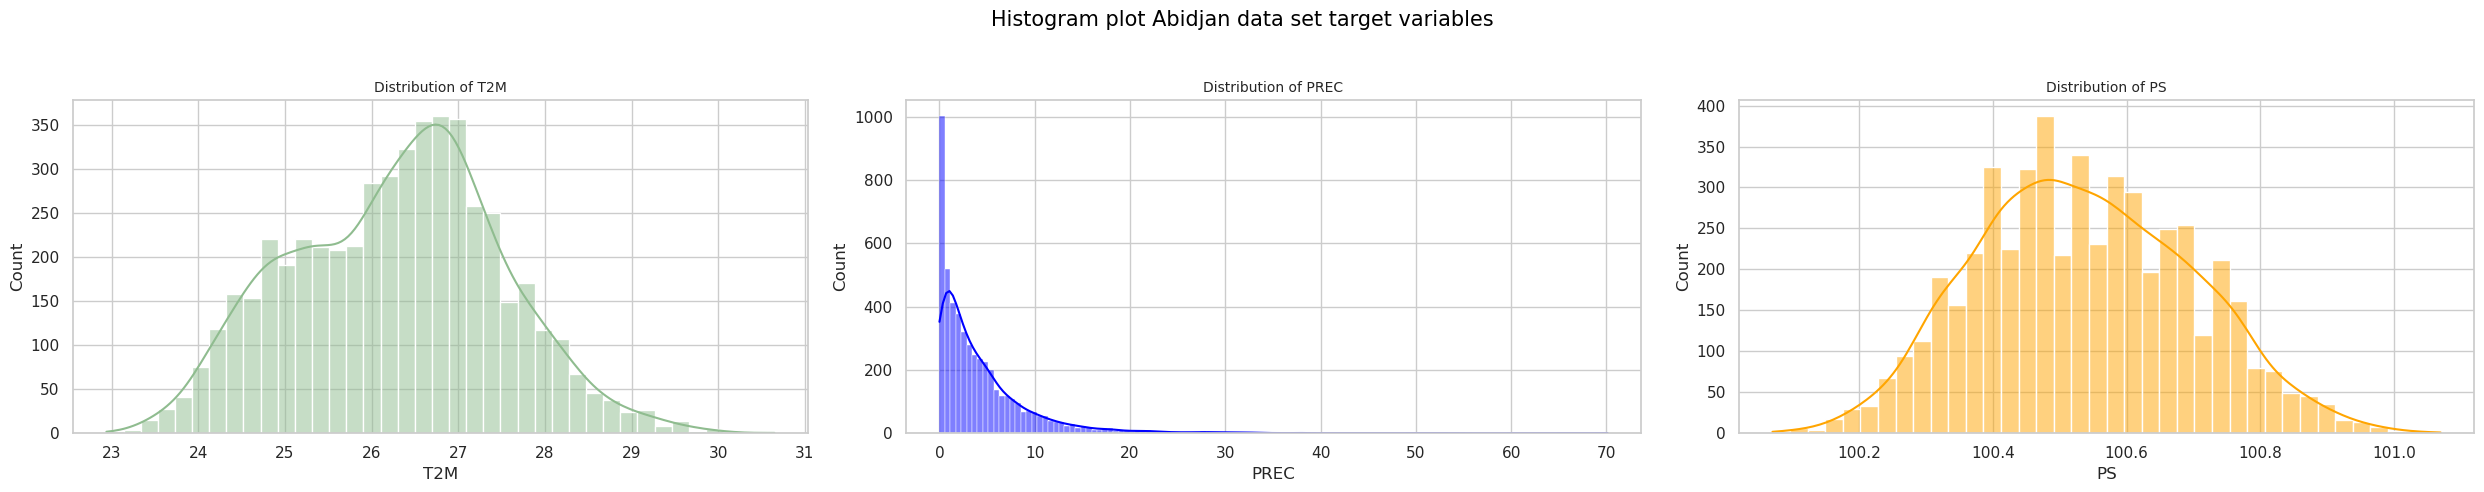

In [943]:
# df['Days'] = pd.to_datetime(df['Days'], dayfirst=True)
# df.index = pd.to_datetime(df['Days'],infer_datetime_format=True )
# plt.figure(figsize=(9,9))
# df.set_index('Days')[['T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
#        'CSSWDW', 'T2MDEW', 'ALLSKYDW']].plot(subplots=True)
#plotting histograms of each category to idenitfy patterns in the data
import matplotlib.pyplot as plt
import seaborn as sns

def showDistributions(df, categories, per_column=True, color=["darkseagreen", "blue", "orange"], title="Original Data"):
    if per_column:
        fig, axes = plt.subplots(1, len(categories), figsize=(25, 5))

        # Ensure color list length matches categories
        if isinstance(color, str):  
            color = [color] * len(categories)  # Convert single color to list
        elif len(color) != len(categories):
            raise ValueError("The length of the color list must match the number of categories.")

        for i in range(len(categories)):
            sns.histplot(data=df, x=categories[i], kde=True, color=color[i], ax=axes[i])
            axes[i].set_title(f"Distribution of {categories[i]}",fontsize=10)

        plt.suptitle(title, fontsize=15, color="black")  # Use a single color
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title

    else:
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.histplot(data=df, x=categories[0], kde=True, color=color[0], ax=ax)  # Use first category for plotting
        ax.set_title(f"Distribution of {categories[0]}")

    plt.show()


showDistributions(Abj_dt,["T2M","PREC","PS"],title="Histogram plot Abidjan data set target variables")

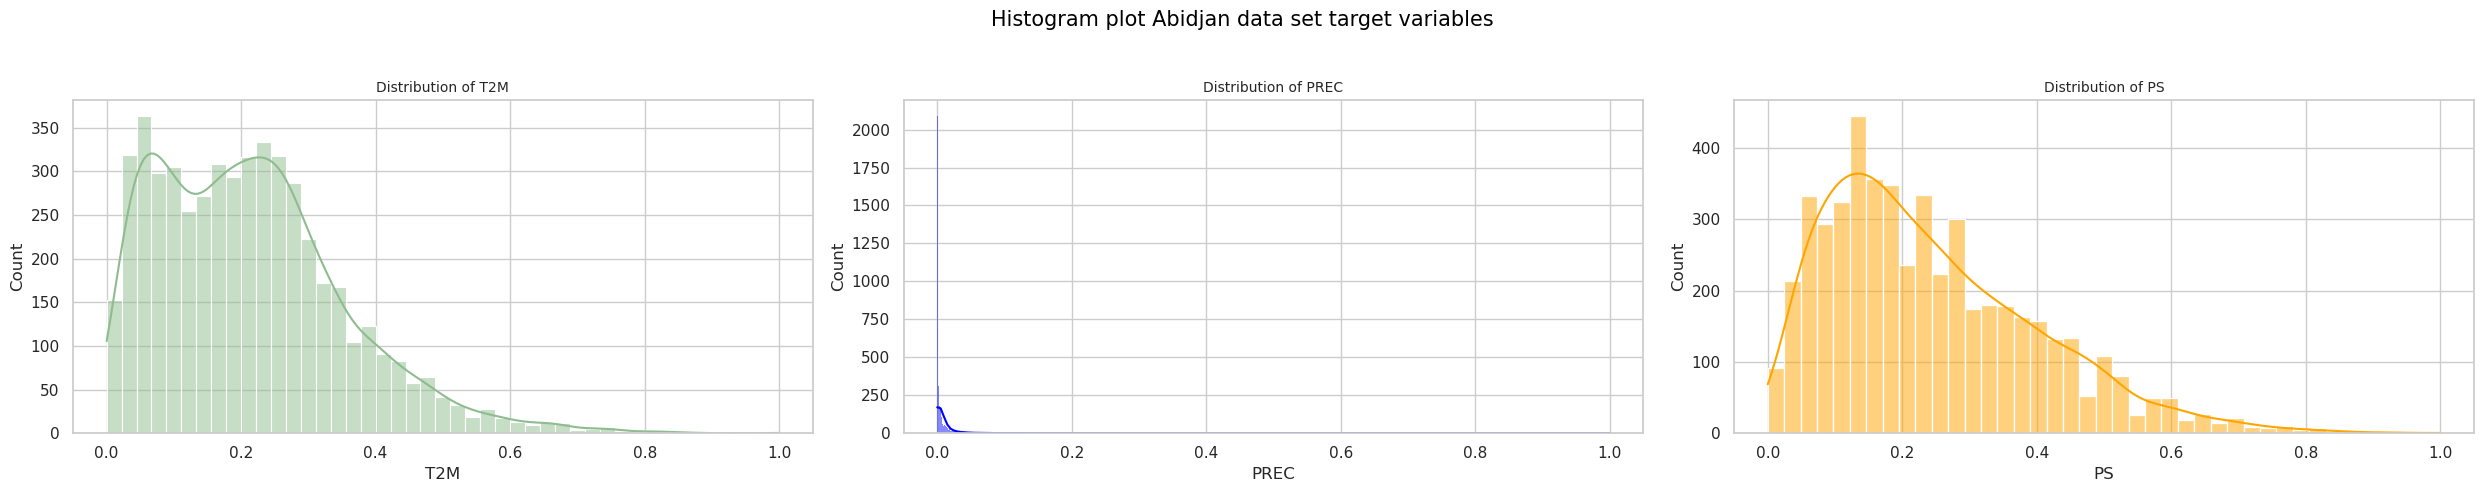

In [1017]:
import copy
Abj_dt_=copy.deepcopy(Abj_dt)
scaler=MinMaxScaler(feature_range=(0,1))
# scaler=StandardScaler()
# def sig(x):
#     return 1/(1+np.exp(-x))
def sq(x):
    return x**2
Abj_dt_[Abj_dt_.columns] = scaler.fit_transform(Abj_dt_[Abj_dt_.columns])
Abj_dt_[Abj_dt_.columns] = sq(Abj_dt_[Abj_dt_.columns])
showDistributions(Abj_dt_,["T2M","PREC","PS"],title="Histogram plot Abidjan data set target variables")

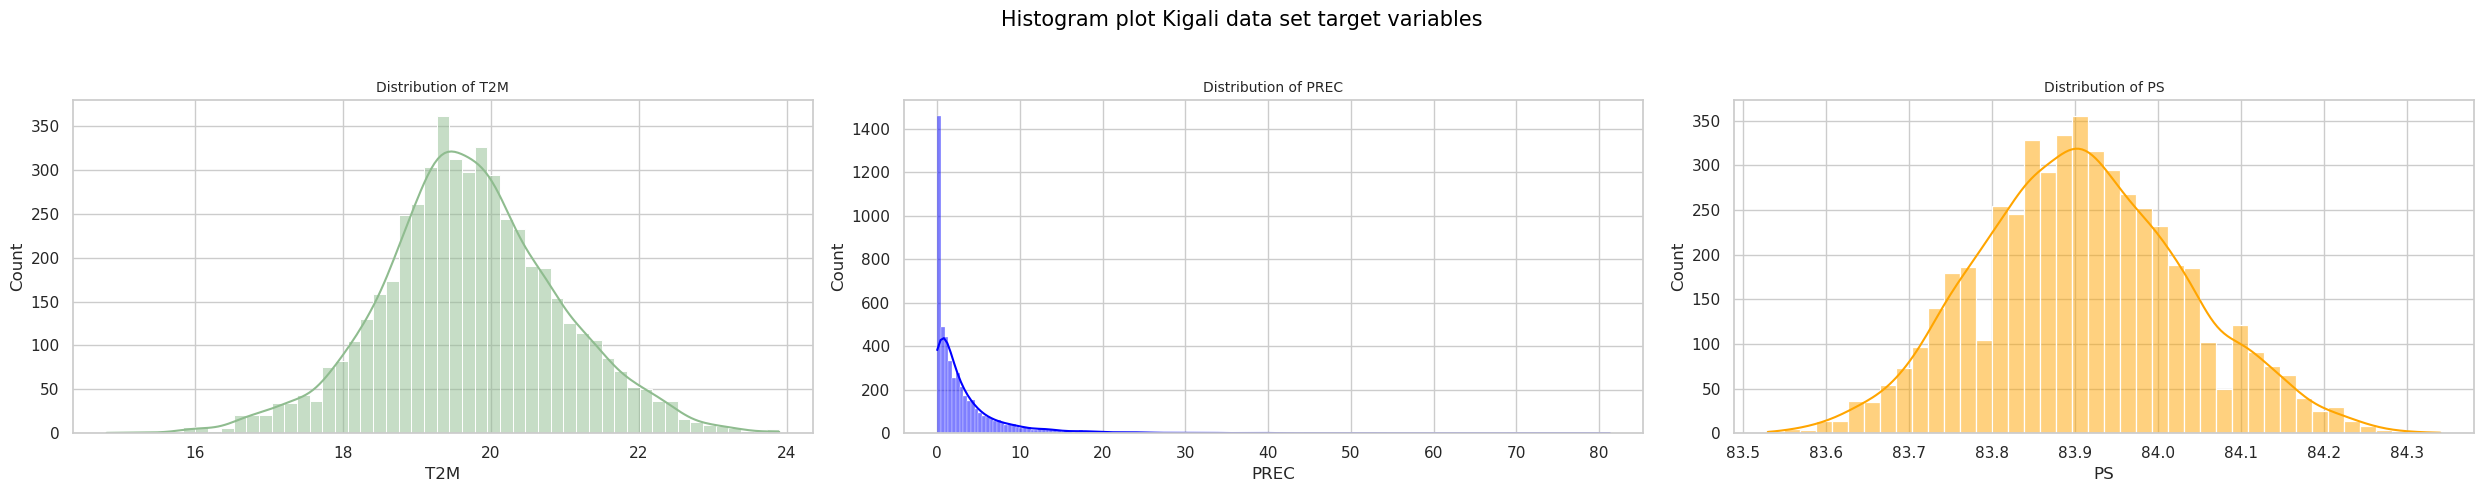

In [944]:
#Handle missing values
showDistributions(Kgl_dt,["T2M","PREC","PS"],title="Histogram plot Kigali data set target variables")
# df = df.fillna(method='ffill')a  # Forward fill for simplicity, or use df.dropna() to remove rows with NaNs
# print(df.isnull().sum())  # Verify no missing values remain


In [946]:
## Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, n_steps_in, n_steps_out,target_names):
        """Initialize the dataset with a pandas DataFrame.
        Parameters:
        - dataframe: Pandas DataFrame containing the time series data.
        - n_steps_in: Number of time steps for input.
        - n_steps_out: Number of time steps for output.
        -target_names: NAmes of the target variables.
        """
        self.dataframe = dataframe
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out   
        self.target_names=target_names   
        # Prepare the input and output sequences
        self.X, self.y = self.sliding_window(self.dataframe, self.n_steps_in, self.n_steps_out,self.target_names)
    def sliding_window(self, dataframe, n_steps_in, n_steps_out,target_names):
        X, y = list(), list()  
        for i in range(len(dataframe)):
            end_idx = i + n_steps_in
            out_end_idx = end_idx + n_steps_out - 1
            # Ensure valid index range
            if out_end_idx >= len(dataframe):
                break
            # Extract X and y sequences
            seq_x = dataframe.iloc[i:end_idx, :].values  # X sequence
            seq_y = dataframe[target_names][end_idx:out_end_idx + 1].values  # y sequence (last column)| Redefine this!!!
            # Check if `seq_y` is shorter than `n_steps_out`
            if len(seq_y) < n_steps_out:
                pad_length = n_steps_out - len(seq_y)
                avg_value = np.mean(seq_y)  # Calculate the average of `seq_y`
                # Pad `seq_y` with the average value
                seq_y = np.pad(seq_y, (0, pad_length), 'constant', constant_values=avg_value)
            # Ensure `seq_y` is a 2D array
            if len(seq_y.shape) == 1:
                seq_y = seq_y.reshape(-1, 1)
            # Append the sequences to the list
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Return the input-output pair for the given index
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
# dt

In [948]:
#################### Datapreprocessing For Temperature   #####################
# Sorting the dates
# Kgl_dt_input= Kgl_dt.sort_index()
# Abj_dt_input= Abj_dt.sort_index()
# Scaling
# scaler = MinMaxScaler()

def Make_tidydata(data, scaler_other, scaler_prec):
    data = data.sort_index()
    # Extract the precipitation column
    prec = data.pop("PREC") 
    # other_ys=data.pop(("T2M","PS")) 
    extracted_cols = data[["T2M", "PS"]].copy()  # make a copy if you want to keep it
    data.drop(columns=["T2M", "PS"], inplace=True)  # remove from original 
    data_concat = pd.concat([data, extracted_cols], axis=1)
    # Fit both scalers on the entire dataset BEFORE splitting
    prec_scaled = scaler_prec.fit_transform(prec.values.reshape(-1, 1))
    data_scaled = scaler_other.fit_transform(data_concat)
    # Convert scaled data back to DataFrame
    data_scaled = pd.DataFrame(data_scaled, columns=data_concat.columns, index=data.index)
    prec_scaled = pd.DataFrame(prec_scaled, columns=["PREC"], index=data.index)
    # Concatenate scaled data
    data_final = pd.concat([data_scaled, prec_scaled], axis=1)

    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data_final) * 0.8)
    val_size = int(train_size * 0.10)

    Xy_train = data_final.iloc[:train_size - val_size].copy()
    Xy_val = data_final.iloc[train_size - val_size:train_size].copy()
    Xy_test = data_final.iloc[train_size:].copy()

    return Xy_train, Xy_val, Xy_test
  
# Create data loaders
def create_data_loaders(TimeSeriesDataset,Make_tidydata,df,target_names,scaler_other, scaler_prec,window_length,obs_length,batch_size):
    Xy_train,Xy_val,Xy_test=Make_tidydata(df,scaler_other, scaler_prec)
    # Creating time series data
    train_dataset = TimeSeriesDataset(Xy_train,obs_length, window_length,target_names)
    val_dataset = TimeSeriesDataset(Xy_val, obs_length, window_length,target_names)
    test_dataset = TimeSeriesDataset(Xy_test, obs_length, window_length,target_names)
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader

# Create DataLoaders for Abidjan and Kigali  
batch_size = 64
window_length = 1
obs_length=14
scaler_other_abj, scaler_prec_abj=[MinMaxScaler(feature_range=(0,1)),MinMaxScaler(feature_range=(-1,1))]
scaler_other_kgl, scaler_prec_kgl=[MinMaxScaler(feature_range=(0,1)),MinMaxScaler(feature_range=(-1,1))]
target_names=['T2M','PS','PREC']
Abj_train_loader,Abj_val_loader,Abj_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Abj_dt,target_names,scaler_other_abj, scaler_prec_abj,window_length,obs_length,batch_size)
Kgl_train_loader,Kgl_val_loader,Kgl_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Kgl_dt,target_names,scaler_other_kgl, scaler_prec_kgl,window_length,obs_length,batch_size)

# Models 

In [901]:
########################################################################################################################
#####################################  Recurrent Network Model for    Temperature prediction       #################################
########################################################################################################################

#LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()       
        # Define LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)     
        # _, (h_n, _) = self.lstm(x)  # Only use the last hidden state
        # h_n = h_n[-1]  
        # Apply dropout to LSTM output
        lstm_out = self.dropout(lstm_out[ :,-1, :])  # Use the output of the last time step   ||| We wiil try to extract the last hidden layer instead h_n[-1,:,:]    
        # Forward pass through Dense layer
        out = self.fc(lstm_out)
        return out
    
#GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()       
        # Define LSTM layer
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        gru_out, _ = self.gru(x)      
        # Apply dropout to LSTM output
        gru_out = self.dropout(gru_out[:, -1, :])  # Use the output of the last time step       
        # Forward pass through Dense layer
        out = self.fc(gru_out)
        return out
#BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])  # Use the output of the last time step
        return out
#BiGRU
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, 
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_gru, _ = self.gru(x)
        out = self.fc(h_gru[:, -1, :])  # Use the output of the last time step
        return out
# # Ensemble
class MyEnsemble(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(MyEnsemble, self).__init__()
        self.lstm_model = LSTMModel(input_dim , hidden_dim, output_dim, dropout_prob=0.2).to(device)
        self.gru_model = GRUModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device)
        self.bilstm = BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
        self.bigrus=BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
        self.weights = nn.Parameter(torch.ones(4))
    def forward(self, x):
        weights_normalized = F.softmax(self.weights, dim=0)
        lstm_out = self.lstm_model(x)
        gru_out = self.gru_model(x)
        bilstm_out = self.bilstm(x)
        bigru_out = self.bigrus(x)
        # Combine the outputs (e.g., by averaging them)
        ensemble_out = weights_normalized [0]*lstm_out + weights_normalized [1]*gru_out + weights_normalized [2]*bigru_out + weights_normalized [3]*bilstm_out 
        return ensemble_out



# Early Stopping Function

In [887]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=50, mode='min', verbose=False, delta=0, save_path=None):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.delta = delta  # Added delta to ignore small improvements
        self.save_path = save_path  # Path to save the best model
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, score, model=None):
        if self.mode == 'min':
            # Check if the score has decreased significantly
            if score < self.best_score - self.delta:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation loss decreased ({self.best_score:.6f} --> {score:.6f}). Saving model...')
                if model and self.save_path:
                    torch.save(model.state_dict(), self.save_path)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')

        elif self.mode == 'max':
            # Check if the score has increased significantly
            if score > self.best_score + self.delta:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation metric increased ({self.best_score:.6f} --> {score:.6f}). Saving model...')
                if model and self.save_path:
                    torch.save(model.state_dict(), self.save_path)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')


<!-- # Model Initialization -->

# Training Recurrent-Based Functions

In [888]:

# Initialize early stopping
patience=50
# Define the loss function and optimizer
criterion = [torch.nn.MSELoss() for i in range(len(target_names))]

#Define metrics
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2,0))
def mse(predictions, targets):
    return torch.mean((predictions - targets) ** 2,0)
def mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets),0)
# Training function
def training_function(model,train_loader,val_loader,optimizer,num_epochs=160):
    train_losses=[]
    val_losses = []
    final_losses=[]
    early_stopping = EarlyStopping(patience=patience, mode='min', verbose=True)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_mse = 0.0
        running_mae = 0.0  
        # Training phase
        for X_batch, y_batch in train_loader:
            X_batch,y_batch=X_batch.to(device),y_batch.to(device).squeeze()
            optimizer.zero_grad()
            # output1,output2,output3 = model(X_batch)
            # y1,y2,y3=y_batch
            # loss
            loss=0
            for i in range(y_batch.shape[1]):
                o_i=model(X_batch)[:,i]
                y_i=y_batch[:,i]
                loss_i=criterion[i](o_i,y_i)
                loss+=loss_i
            # print("output size:",outputs.shape,"y_batch:",y_batch.shape )
            # loss = criterion(outputs, y_batch)    
            # loss=torch.mean((outputs-y_batch)**2,axis=0)
            # print()
            loss.backward()
            optimizer.step()
            # print("loss:",loss,"loss shape:",loss.shape)
            running_loss += loss * X_batch.size(0)  
            outputs = model(X_batch)    
            running_mse += mse(outputs, y_batch) * X_batch.size(0)
            running_mae += mae(outputs, y_batch) * X_batch.size(0)
        # Cumulative training loss 
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_mse = running_mse / len(train_loader.dataset)
        epoch_train_mae = running_mae / len(train_loader.dataset)
        train_losses.append(epoch_train_mse.detach())
        # Validation phase 
        model.eval() # Set model to validation model
        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch,y_batch=X_batch.to(device),y_batch.to(device).squeeze()              
                outputs = model(X_batch)
                val_mse += mse(outputs, y_batch) * X_batch.size(0)
                val_mae += mae(outputs, y_batch) * X_batch.size(0)
        # Cumulative validation loss 
        # epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_mse = val_mse / len(val_loader.dataset)
        epoch_val_mae = val_mae / len(val_loader.dataset)
        val_losses.append(epoch_val_mse.detach())
        if (epoch+1)%5==0:
            # Print losses and metrics
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Combined Loss:{epoch_train_loss:.4f}, Training Loss: {epoch_train_mse}, MAE: {epoch_train_mae}') #,
            print(f'Validation Loss: {epoch_val_mse}, MAE: {epoch_val_mae}') # MSE: {epoch_val_loss}
            # print(f'Training Loss: {epoch_train_loss}, MSE: {epoch_train_mse}, MAE: {epoch_train_mae}') #:.4f
            # print(f'Validation Loss: {epoch_val_loss}, MSE: {epoch_val_mse}, MAE: {epoch_val_mae}')
            print('------------------------------------')  
        # Check early stopping
        early_stopping(torch.mean(epoch_val_mse).item())
        if early_stopping.early_stop:
            print('Early stopping')
            break
        #[epoch_train_loss,epoch_train_mse,epoch_train_mae]
        # final_losses.append([epoch_train_loss.detach(),epoch_train_mse.detach(),epoch_train_mae.detach(),epoch_val_mse,epoch_val_mae])
    train_losses = np.vstack([tensor.detach().cpu().numpy() for tensor in train_losses])
    val_losses = np.vstack([tensor.detach().cpu().numpy() for tensor in val_losses])
    return train_losses,val_losses

* Make the plots of the lurning curves for each models and per city.
* Write a for loop to automate the process evoked above and another for loop for the predictions per models and per city.

In [1177]:
# # np.mean([0.2672, 0.0064, 0.2475]),np.mean([0.2672, 0.0064, 0.2475])

# path= "/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Models"
# if os.path.exists(path):
#     print("Path exists!")
# else:
#     print("Path does not exist!")

In [902]:
# Data Loaders
dt_loaders = [[Kgl_train_loader, Kgl_val_loader], [Abj_train_loader, Abj_val_loader]]


# Labels
model_name = ["LSTM", "GRU", "BiLSTM", "BiGRU", "Ensemble Learning"]
data_name = ["Kigali", "Abidjan"]

# Training history storage
history_container = [[], []]
model_container={"Kigali":[],"Abidjan":[]}
# Loop through data loaders
for idx, data in enumerate(dt_loaders):
    # Model initialization
    models = [
        LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device),
        GRUModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device),
        BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device),
        BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device),
        MyEnsemble(input_dim, hidden_dim, output_dim, num_layers).to(device),
    ]
    
    # Create optimizers for each model
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    for idx_m, (model, opt) in enumerate(zip(models, optimizers)):
        history = training_function(model, data[0], data[1], opt, num_epochs=100)
        history_container[idx].append(history)
        model_container[data_name[idx]].append(model)
        # # Save model
        # model_path = os.path.join(path, f"model_{model_name[idx_m]}_{data_name[idx]}.pt")
        # torch.save(model.state_dict(), model_path)  # Save model state_dict instead of full model




Validation loss decreased (0.359740 --> 0.359740). Saving model...
Validation loss decreased (0.315856 --> 0.315856). Saving model...
Validation loss decreased (0.277630 --> 0.277630). Saving model...
Validation loss decreased (0.244539 --> 0.244539). Saving model...
Epoch 5/100
Combined Loss:0.7520, Training Loss: tensor([0.0395, 0.0268, 0.6841], device='cuda:0', grad_fn=<DivBackward0>), MAE: tensor([0.1650, 0.1312, 0.8183], device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor([0.0183, 0.0236, 0.6057], device='cuda:0'), MAE: tensor([0.1143, 0.1190, 0.7597], device='cuda:0')
------------------------------------
Validation loss decreased (0.215853 --> 0.215853). Saving model...
Validation loss decreased (0.190881 --> 0.190881). Saving model...
Validation loss decreased (0.169026 --> 0.169026). Saving model...
Validation loss decreased (0.149868 --> 0.149868). Saving model...
Validation loss decreased (0.132977 --> 0.132977). Saving model...
Epoch 10/100
Combined Loss:0.3986,

### Learning plot of each models

In [791]:
# Assume these are your histories
# all_history = [history_lstm, history_gru, history_bilstm, history_bigru]
# all_history=[history_ens]
data_name=["Kigali","Abidjan"]
model_name=["LSTM","GRU","BiLSTM","BiGRU","Ensemble Learning"]
# Create a figure and a set of subplots
 # One subplot per model
# axs=axs.flatten()
# Loop through each history and corresponding axis
# for dt_idx in range(len(history_container)):

def plot_L_curves(hist_per_data_Mdls,target_names,model_name,data_name:str):
    # hist_per_data_Mdls=history_container[dt_idx]
    
    fig, axs = plt.subplots(5,3, figsize=(14, 12)) 
    for j, name in enumerate(target_names):
        for i, history in enumerate(hist_per_data_Mdls):
            
            train_losses, val_losses= hist_per_data_Mdls[i]
            epochs=[i for i in range(len(train_losses))]
            axs[i,j].plot(epochs,train_losses[:,j], label='Training Loss')
            axs[i,j].plot(epochs,val_losses[:,j], label='Validation Loss')
            axs[i,j].set_title(f'{data_name} {target_names[j]} using {model_name[i]}',fontsize=10)
            axs[i,j].set_xlabel('Epochs')
            axs[i,j].set_ylabel('Loss')
            axs[i,j].legend()
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
# dt_idx=0
# hist_per_data_Mdls=history_container[dt_idx]
# plot_L_curves(hist_per_data_Mdls,target_names,model_name,data_name[dt_idx])


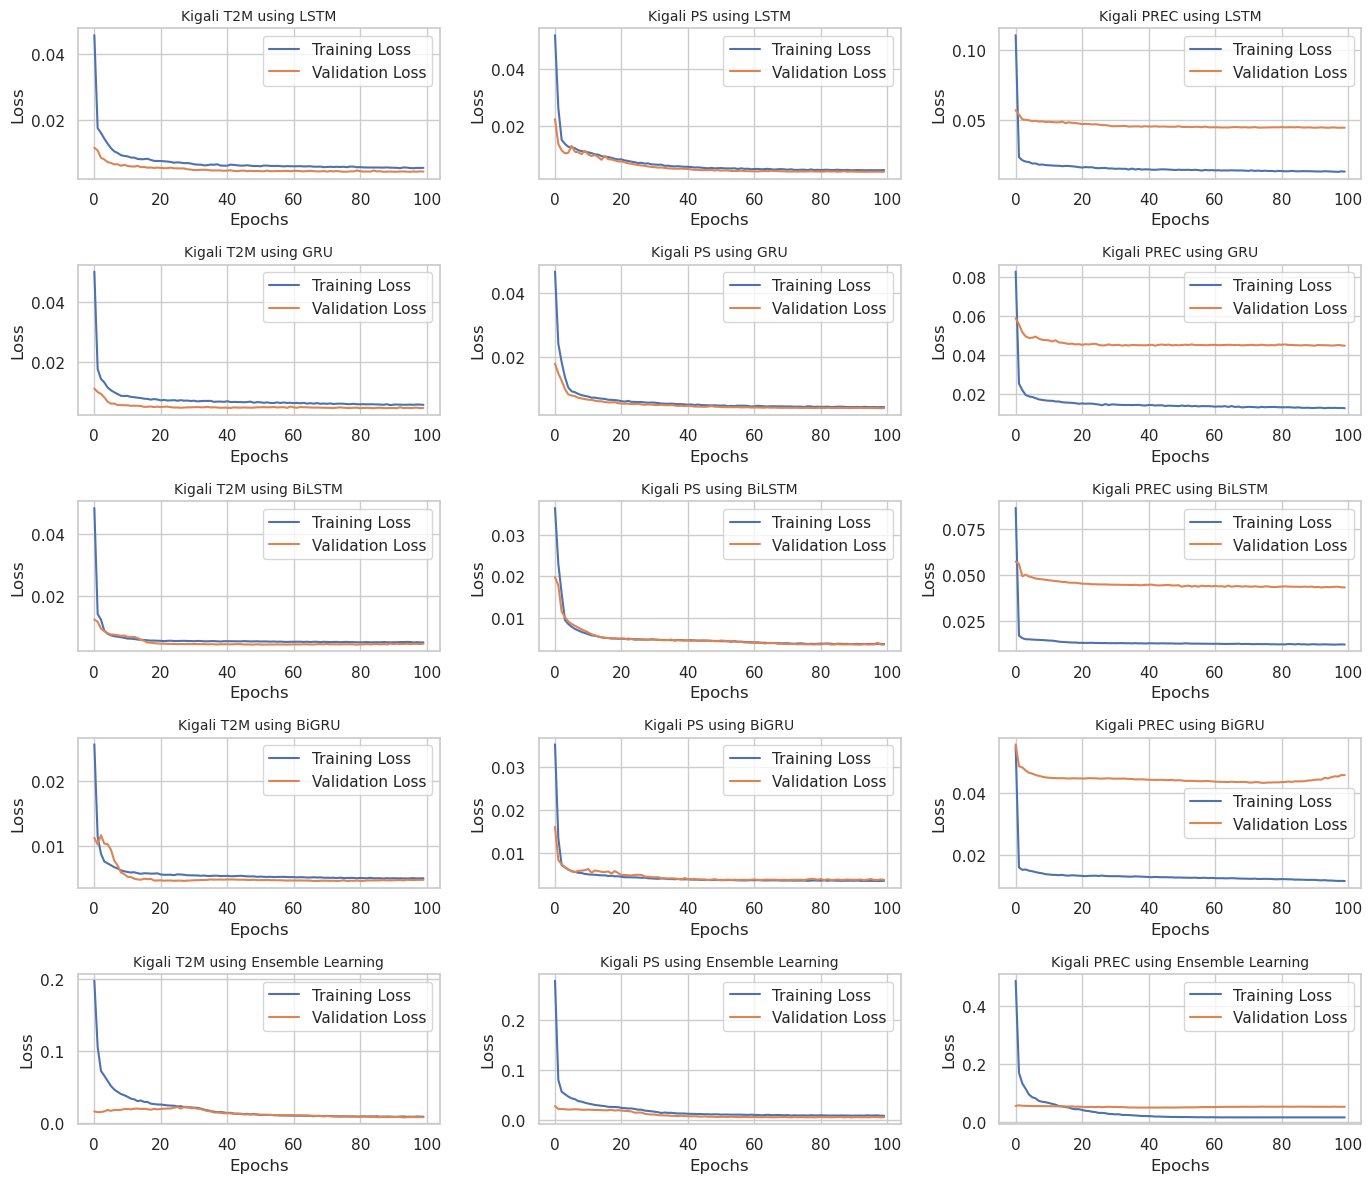

In [792]:
plot_L_curves(history_container[0],target_names,model_name,data_name[0])
# history_container[1]
# data_name[1]

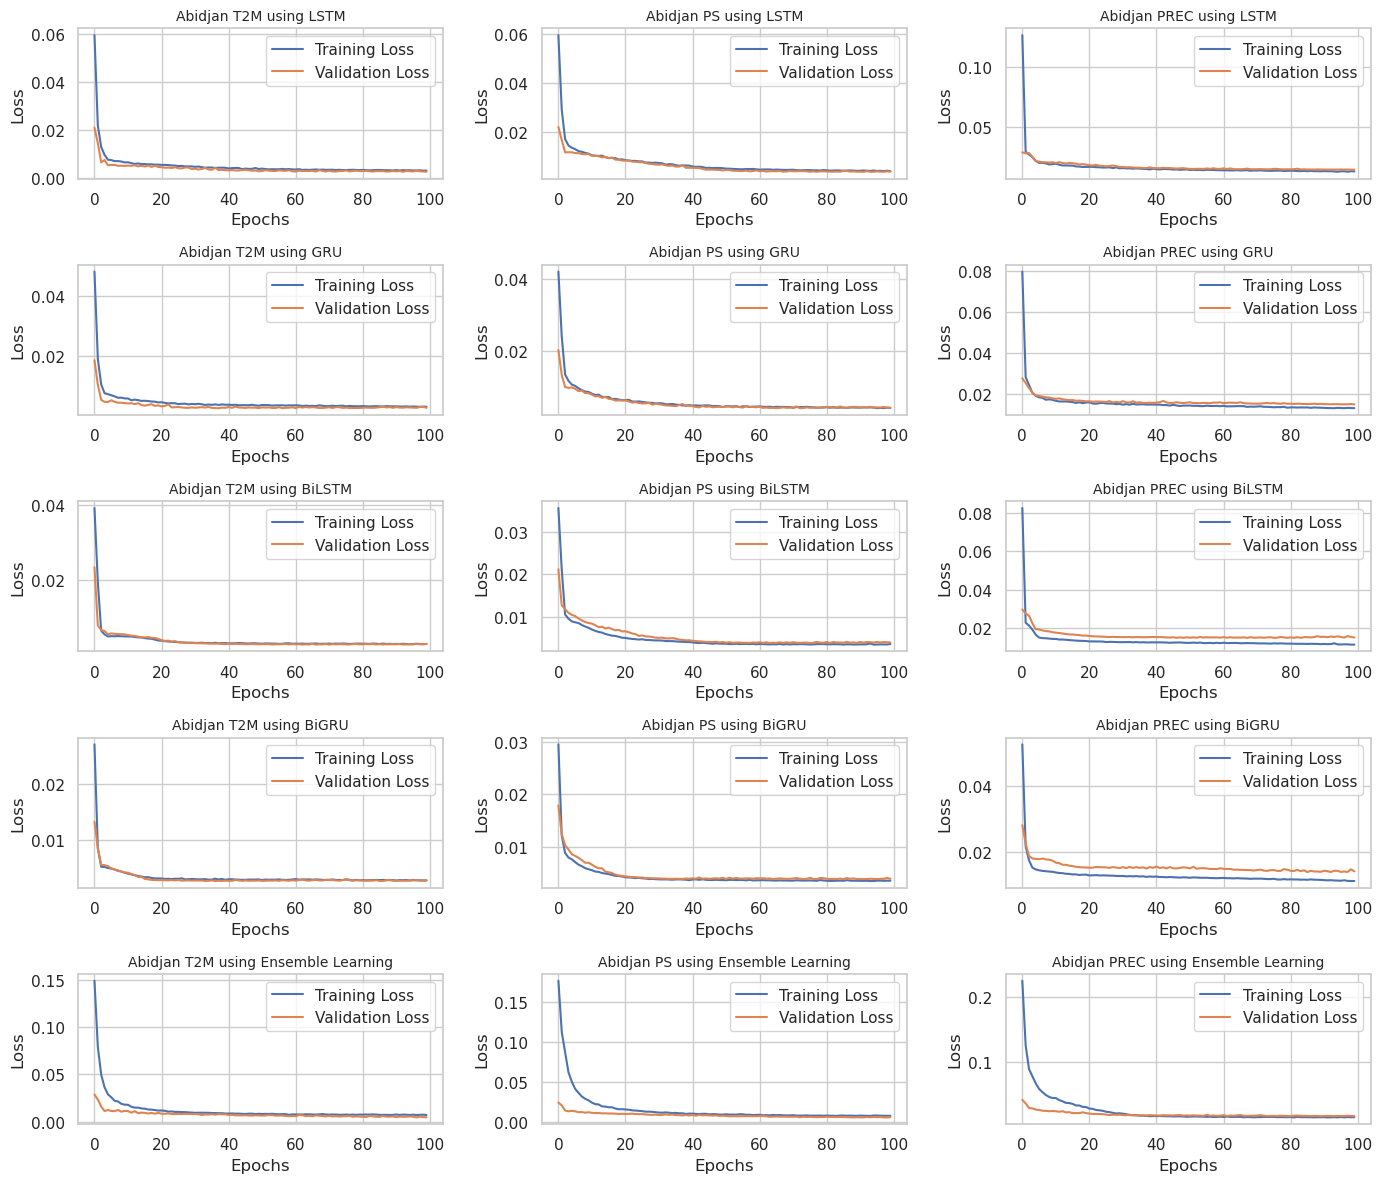

In [793]:
plot_L_curves(history_container[1],target_names,model_name,data_name[1])

# Predictions

In [896]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_pred,y_true): 
    return torch.mean(torch.abs((y_true - y_pred) / (y_true+0.000001)),dim=0) * 100
def r2_squared(y_pred,y_true):
    # Compute mean of y_true along rows (axis=0), for each variable
    y_mean = torch.mean(y_true, dim=0)  # Shape: (variables,)
    # Compute residual sum of squares (SS_res) for each variable
    ss_res = torch.sum((y_true - y_pred) ** 2, dim=0)  # Shape: (variables,)
    # Compute total sum of squares (SS_tot) for each variable
    ss_tot = torch.sum((y_true - y_mean) ** 2, dim=0)  # Shape: (variables,)
    # Compute R^2 for each variable
    r2_scores = 1 - (ss_res / ss_tot)  # Shape: (variables,)
    # print((ss_res / ss_tot) )
    # ls=[]
    # for i in range(3):
    return r2_scores
scaler_dict={"Kigali":[scaler_other_kgl, scaler_prec_kgl],"Abidjan":[scaler_other_abj, scaler_prec_abj]}



In [794]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
scaler_dict={"Kigali":[scaler_other_kgl, scaler_prec_kgl],"Abidjan":[scaler_other_abj, scaler_prec_abj]}

def evaluate_and_plot(model_container, test_loader_list, scaler_dict, device, target_names=['T2M', 'PS', 'PREC']):
    metrics_list = []
    
    for idx, (city, models) in enumerate(model_container.items()):
        # test_loader = test_loader_list[idx]  # Fetch the correct test loader
        # scaler_ = scaler_dict[city]  # Use a dictionary lookup instead of hardcoding indices
        test_loader = test_loader_list[idx]  # Fetch the correct test loader
        scaler_other, scaler_prec= scaler_dict[city]  # Use a dictionary lookup instead of hardcoding indices
        
        for model in models:
            model_name = model.__class__.__name__  # Get model class name as identifier
            model.to(device)
            model.eval()
            
            y_true_list = []
            y_pred_list = []
            
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.squeeze().to(device)
                    outputs = model(X_batch)

                    y_true_list.append(y_batch.cpu().numpy())
                    y_pred_list.append(outputs.cpu().numpy())
            
            # Convert lists to NumPy arrays
            y_true = np.concatenate(y_true_list)
            y_pred = np.concatenate(y_pred_list)

            # Extract the precipitation variables
            prec_y=y_true[:,-1]
            prec_pred=y_pred [:,-1]
            
            # Inverse transform
            dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2] - 3)) # -3 because we exclude the precipitation
            actuals_padded = np.hstack([dummy_features, y_true[:,:-1]])
            predictions_padded = np.hstack([dummy_features, y_pred[:,:-1]])
            # inverse the concatenated matrix with the two variables (T2M and PS)
            actuals__other = scaler_other.inverse_transform(actuals_padded)[:, -2:]
            predictions__other= scaler_other.inverse_transform(predictions_padded)[:, -2:]
            # inverse the precipitation variable from predicted and actual values
            prec_pred_var=scaler_prec.inverse_transform(prec_pred.reshape(-1,1))
            prec_actual_var=scaler_prec.inverse_transform(prec_y.reshape(-1,1))
            # Concatenate
            actuals_=np.concatenate((actuals__other, prec_actual_var),axis=1)
            predictions_= np.concatenate((predictions__other,prec_pred_var),axis=1)
            # # Inverse transform
            # dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2] - 3))
            # actuals_padded = np.hstack([dummy_features, y_true])
            # predictions_padded = np.hstack([dummy_features, y_pred])
            
            # actuals_ = scaler_.inverse_transform(actuals_padded)[:, -3:]
            # predictions_ = scaler_.inverse_transform(predictions_padded)[:, -3:]

            # Create a figure with subplots
            fig, axes = plt.subplots(len(target_names), 2, figsize=(12, 10))  
            fig.suptitle(f"{city} - {model_name} Predictions vs. Actuals", fontsize=14, fontweight="bold")

            for i, var_name in enumerate(target_names):
                actual = actuals_[:, i]
                pred = predictions_[:, i]

                # Compute metrics
                mse_ = np.mean((actual - pred) ** 2)
                rmse_ = np.sqrt(mse_)
                mae_ = np.mean(np.abs(actual - pred))
                r2_ = 1 - (np.sum((actual - pred) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

                # Handle potential division by zero in MAPE
                mask = actual != 0
                mape_ = np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100 if mask.any() else np.nan

                # Store metrics
                metrics_list.append({
                    "City": city,
                    "Model": model_name,
                    "Variable": var_name,
                    "MSE": round(mse_,4),
                    "RMSE": round(rmse_,4),
                    "MAE": round(mae_,4),
                    "R²": round(r2_,4),
                    "MAPE": round(mape_,4)
                })

                # --- Subplot 1: Line Plot ---
                ax1 = axes[i, 0]
                ax1.plot(actual, label="Actual", color="blue", alpha=0.7)
                ax1.plot(pred, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
                ax1.set_title(f"{var_name} - Time Series")
                ax1.set_xlabel("Time Step")
                ax1.set_ylabel(var_name)
                ax1.legend()

                # --- Subplot 2: Histogram ---
                ax2 = axes[i, 1]
                sns.histplot(actual, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=ax2)
                sns.histplot(pred, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=ax2)
                ax2.set_title(f"{var_name} - Distribution")
                ax2.set_xlabel(var_name)
                ax2.set_ylabel("Frequency")
                ax2.legend()

            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
            plt.show()
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df


In [903]:
scaler_dict={"Kigali":[scaler_other_kgl, scaler_prec_kgl],"Abidjan":[scaler_other_abj, scaler_prec_abj]}
test_loader_list=[Kgl_test_loader,Abj_test_loader]
all_metrics=evaluate_model(model_container, test_loader_list, scaler_dict, device)
all_metrics#to_latex()

City       Model Variable        MSE      RMSE       MAE        R²  \
0   Kigali  MyEnsemble      T2M   0.572913  0.756910  0.590020  0.634116   
1   Kigali  MyEnsemble       PS   0.003893  0.062392  0.048924  0.772735   
2   Kigali  MyEnsemble     PREC  31.438349  5.606991  3.243917  0.162760   
3  Abidjan  MyEnsemble      T2M   0.289635  0.538177  0.414037  0.726453   
4  Abidjan  MyEnsemble       PS   0.005951  0.077140  0.060824  0.760414   
5  Abidjan  MyEnsemble     PREC  41.618854  6.451268  3.607911  0.146536   

          MAPE  
0     3.106805  
1     0.058296  
2  1302.405732  
3     1.606015  
4     0.060495  
5   709.994714

In [ ]:
# all_metrics.to_csv("all_metrics_ens.csv")

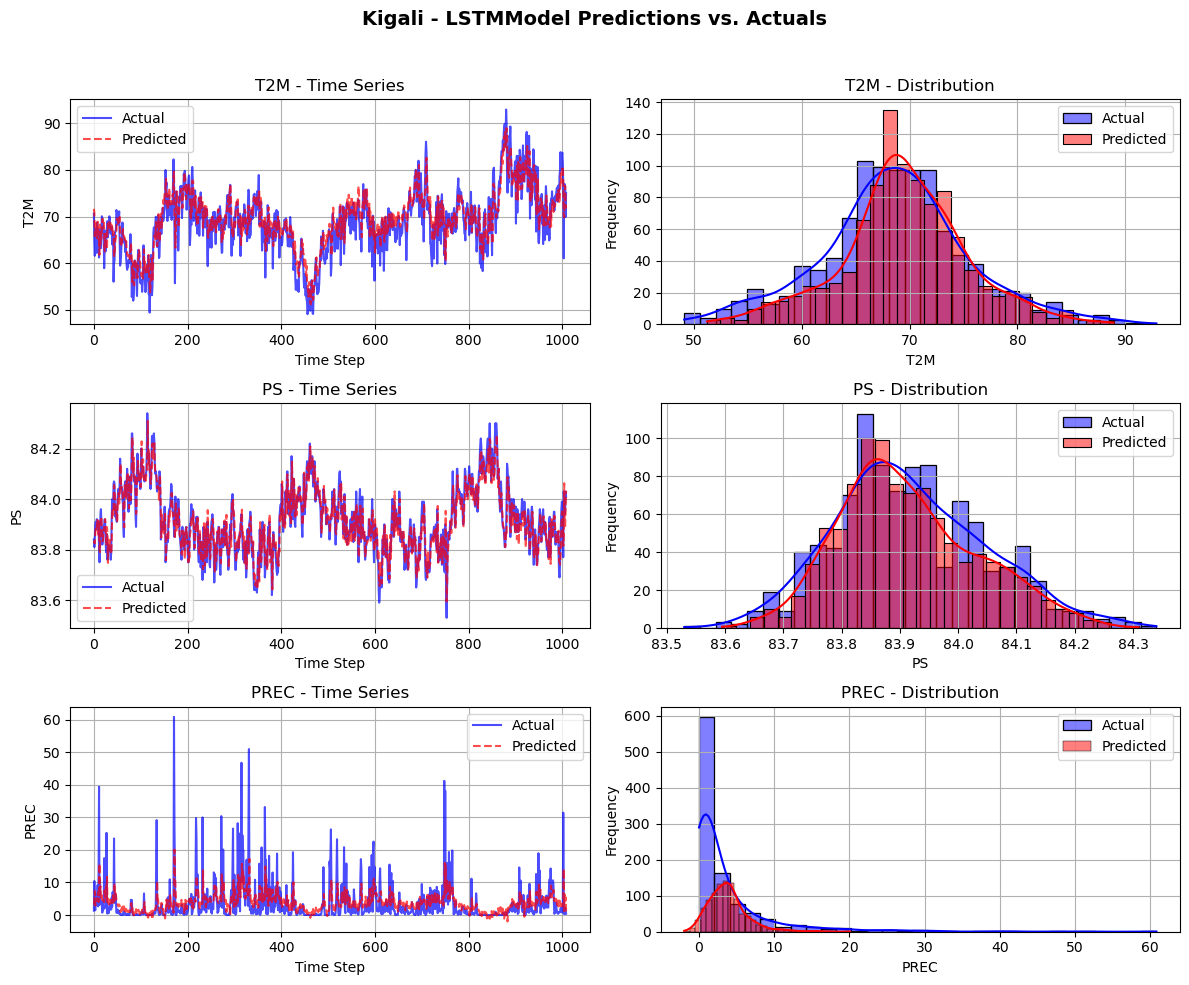

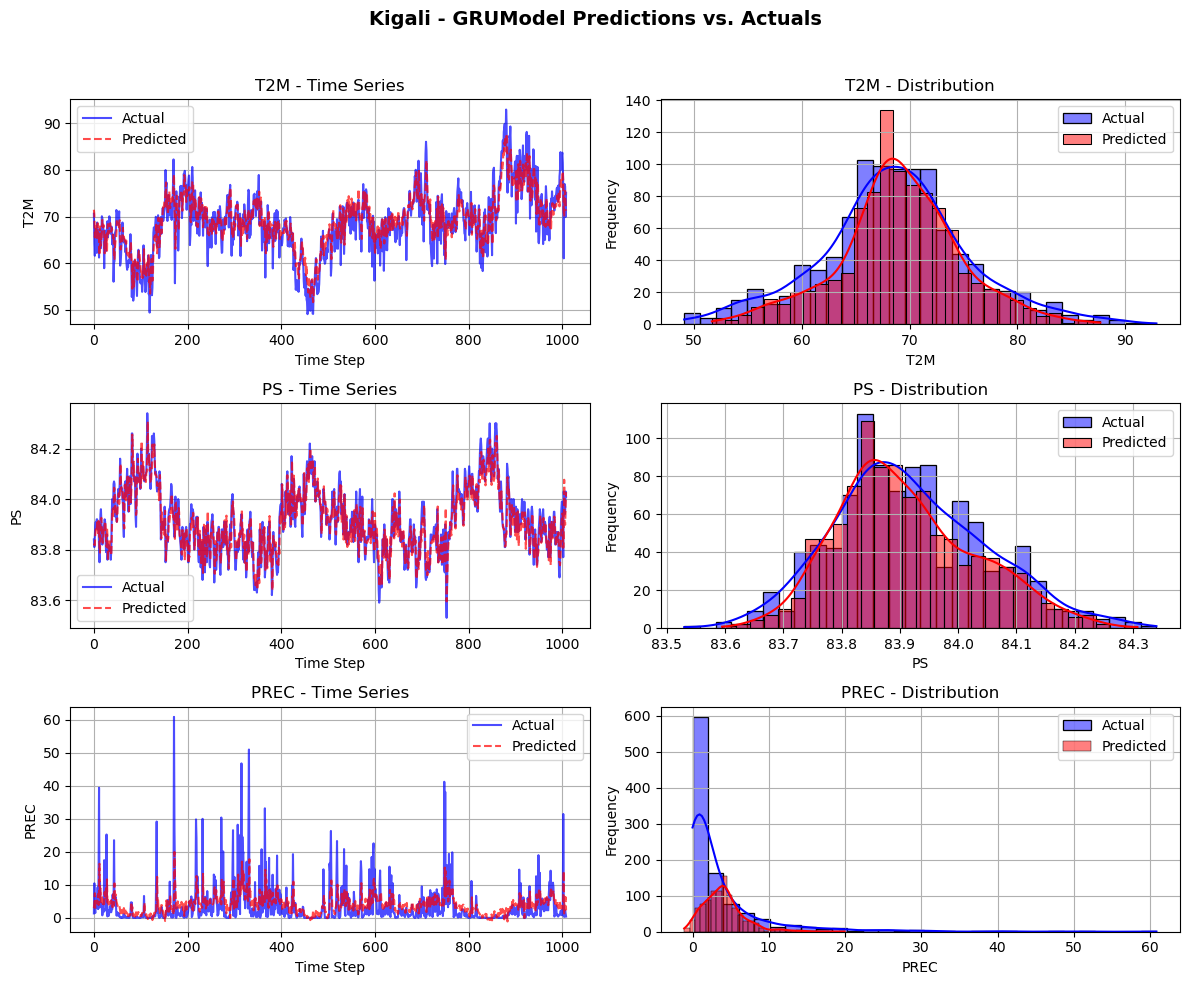

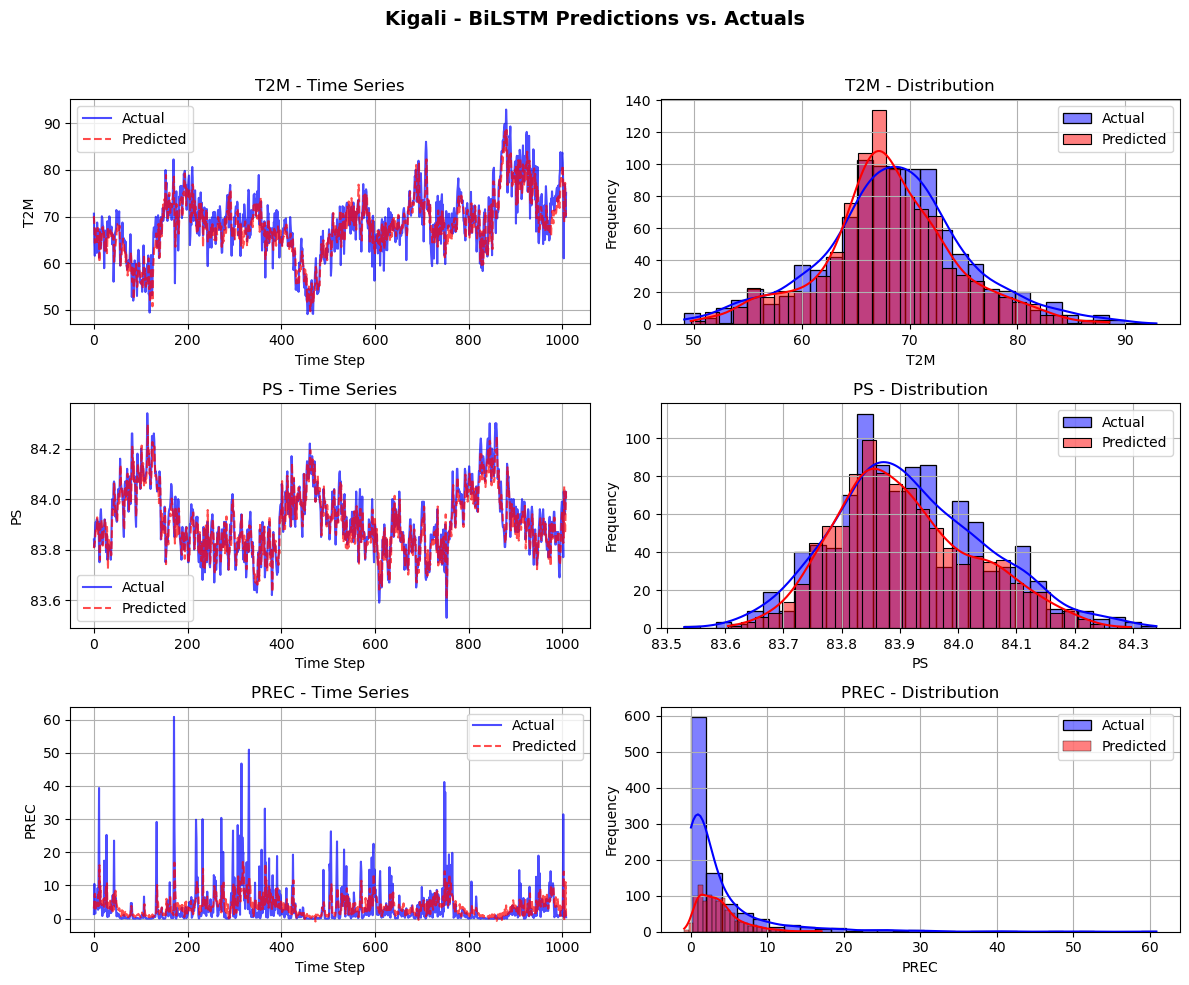

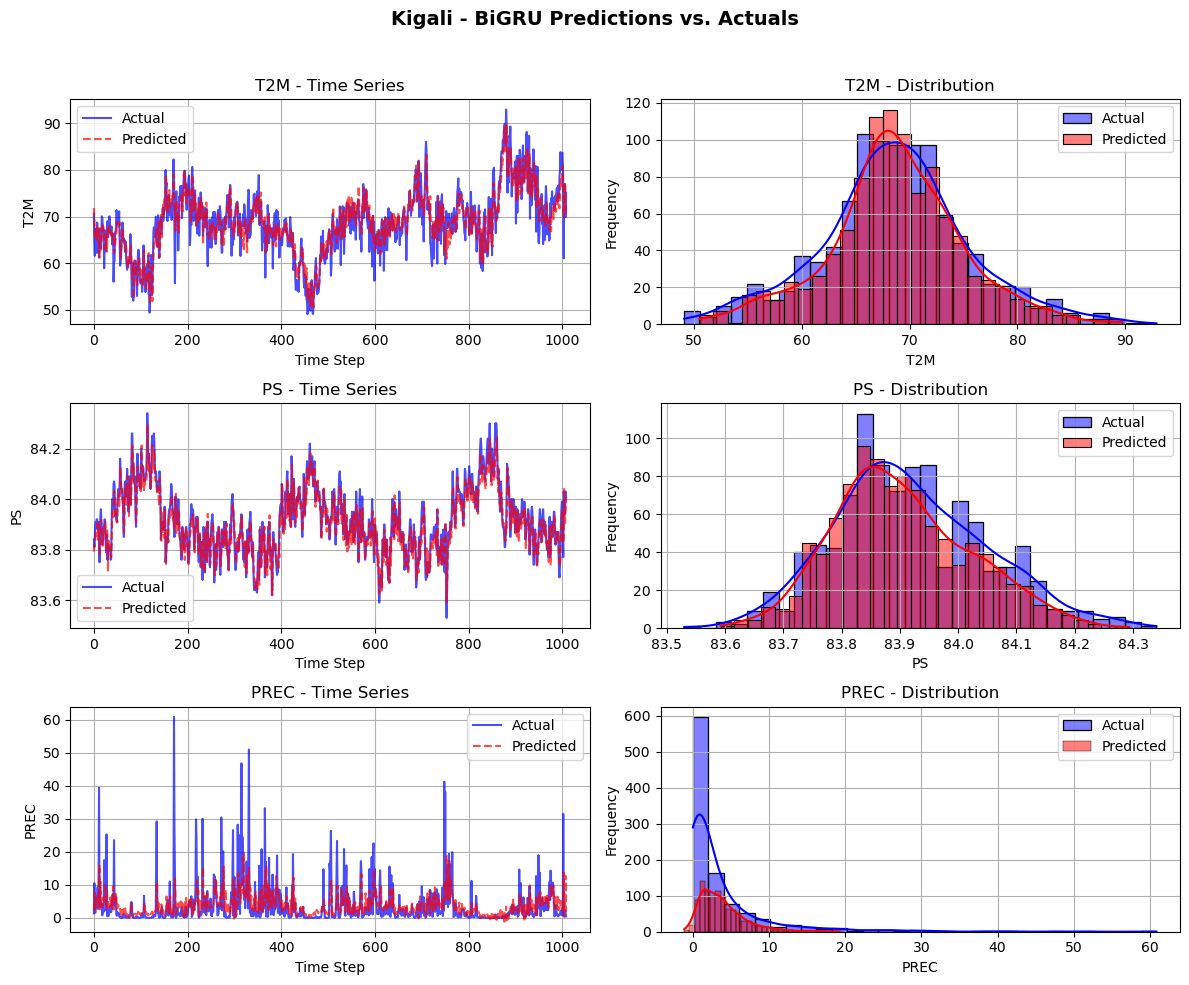

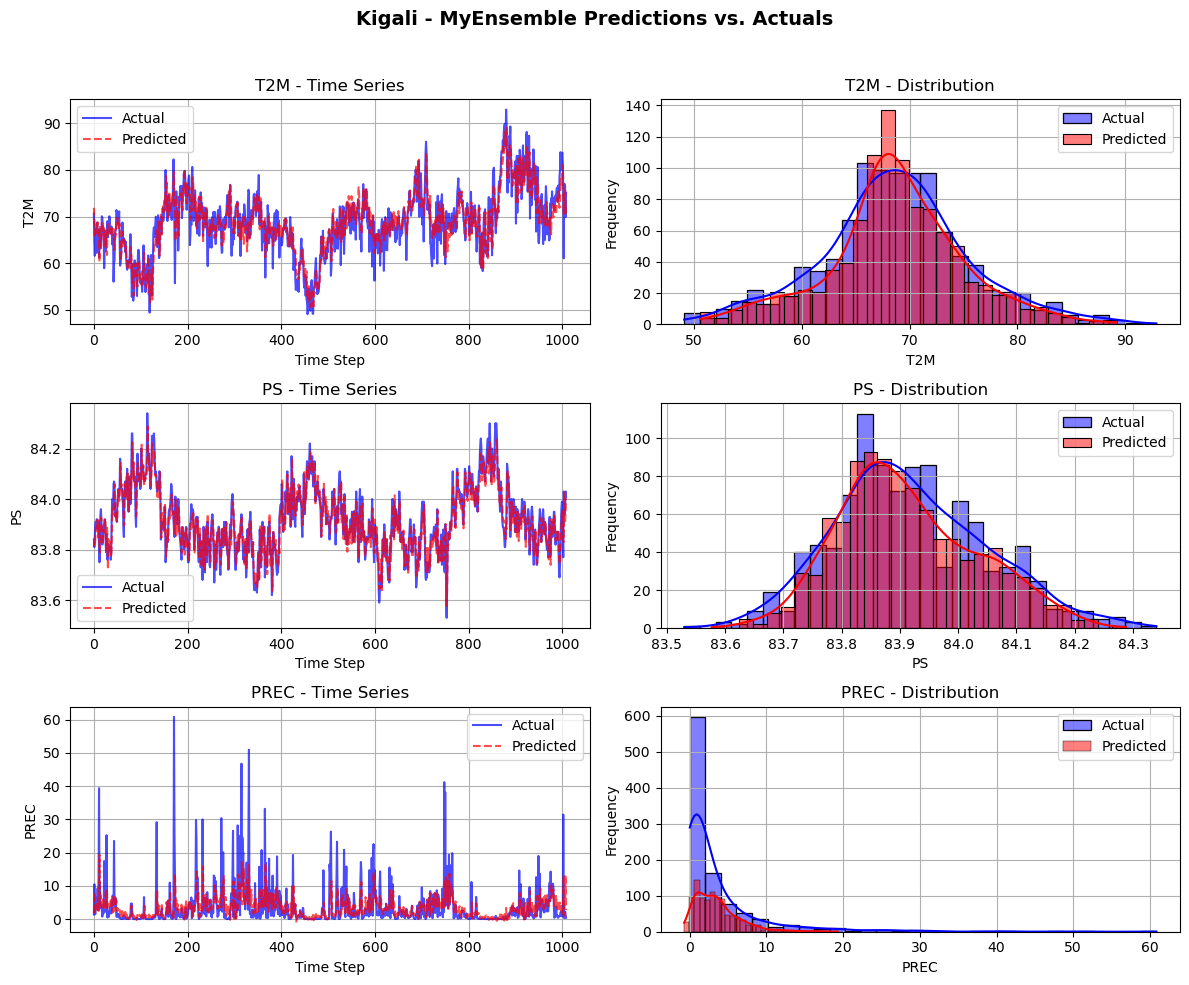

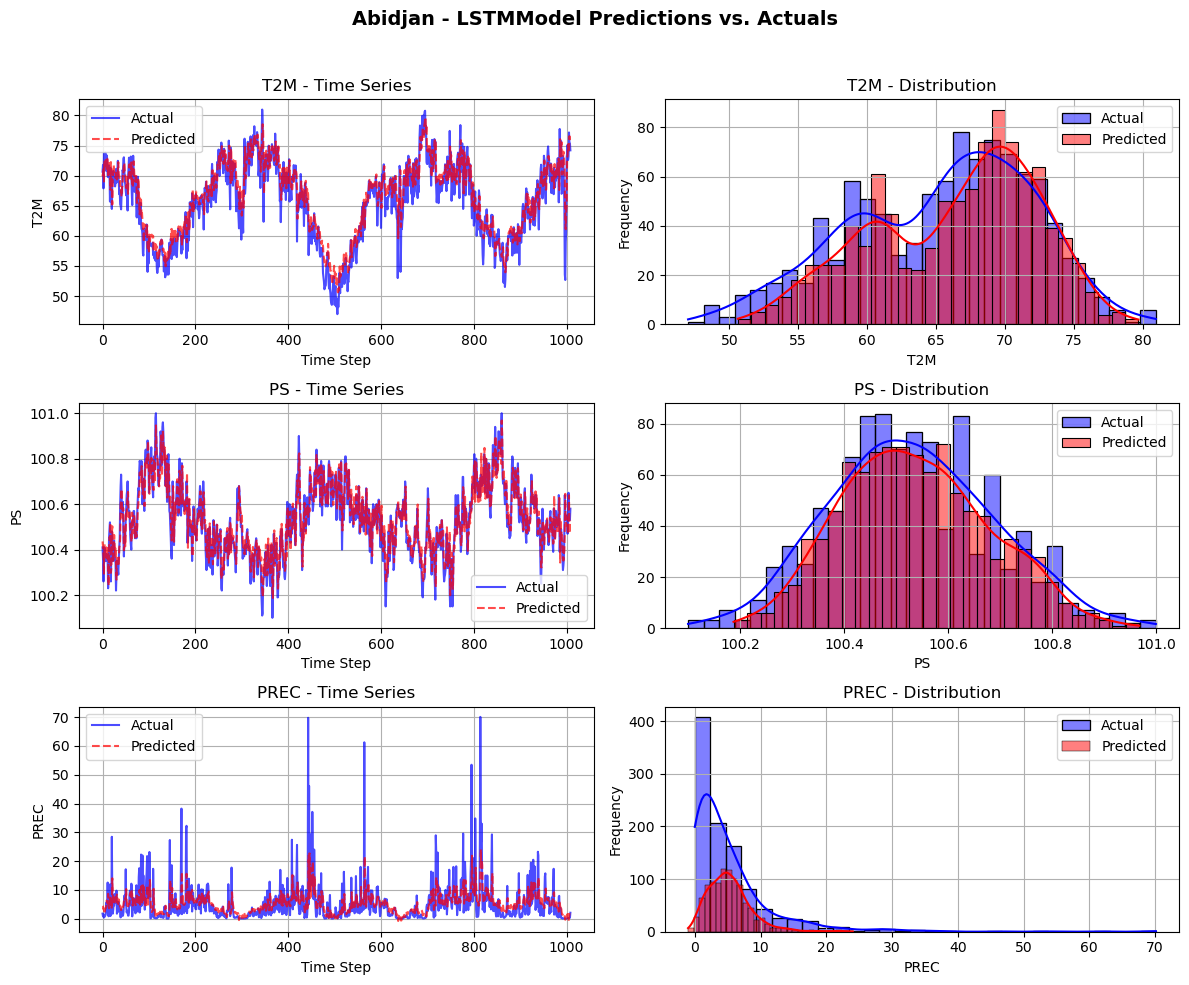

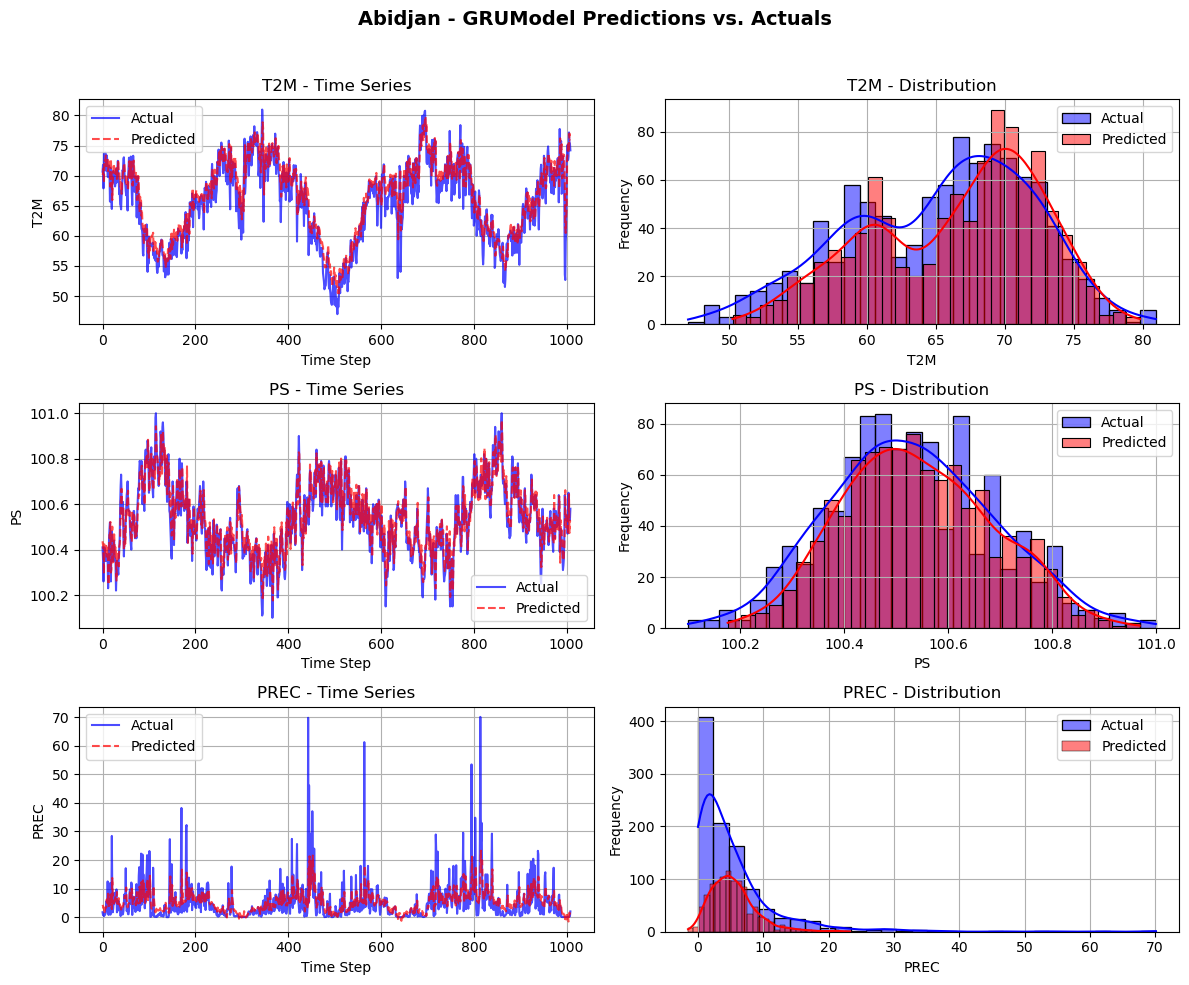

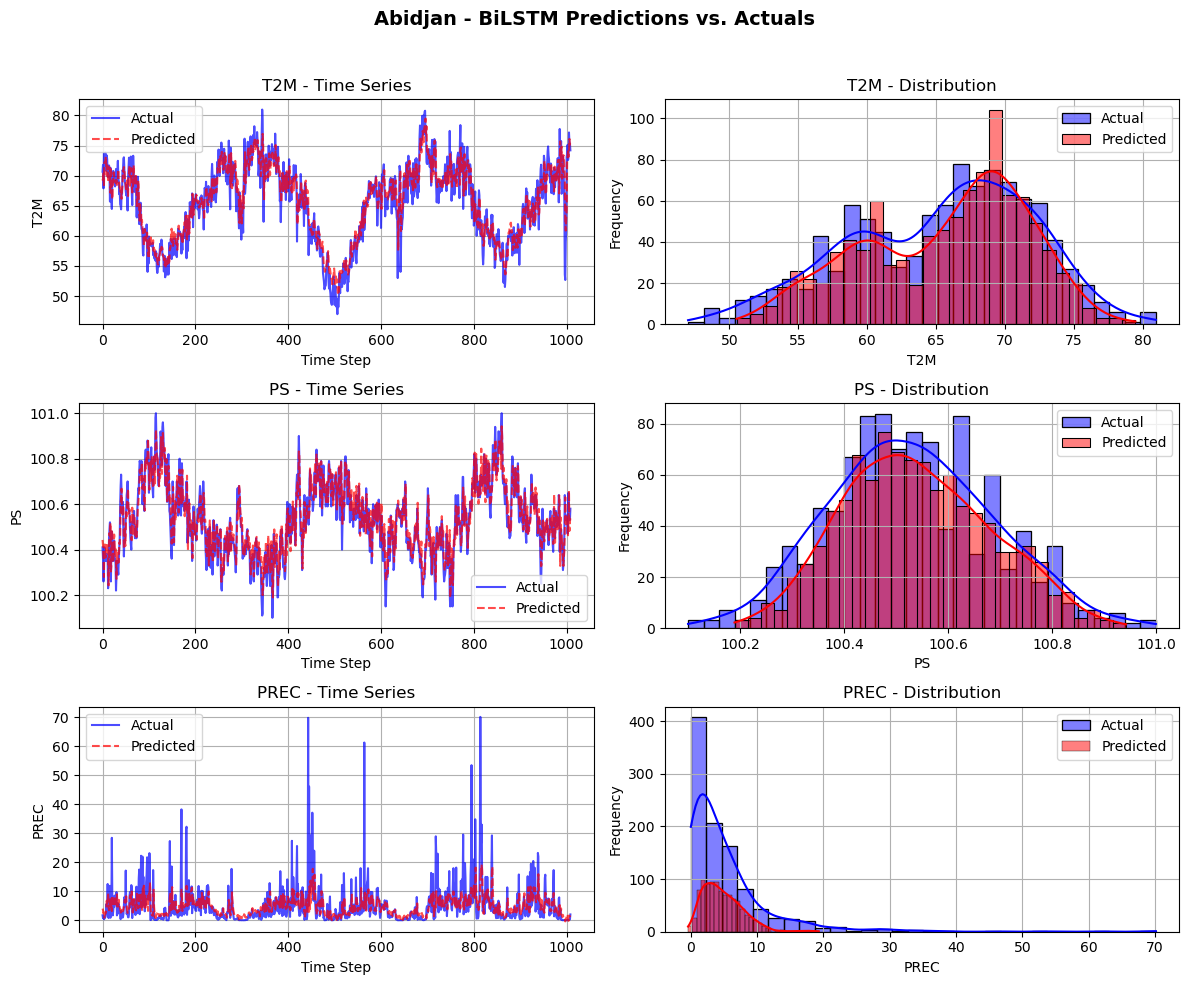

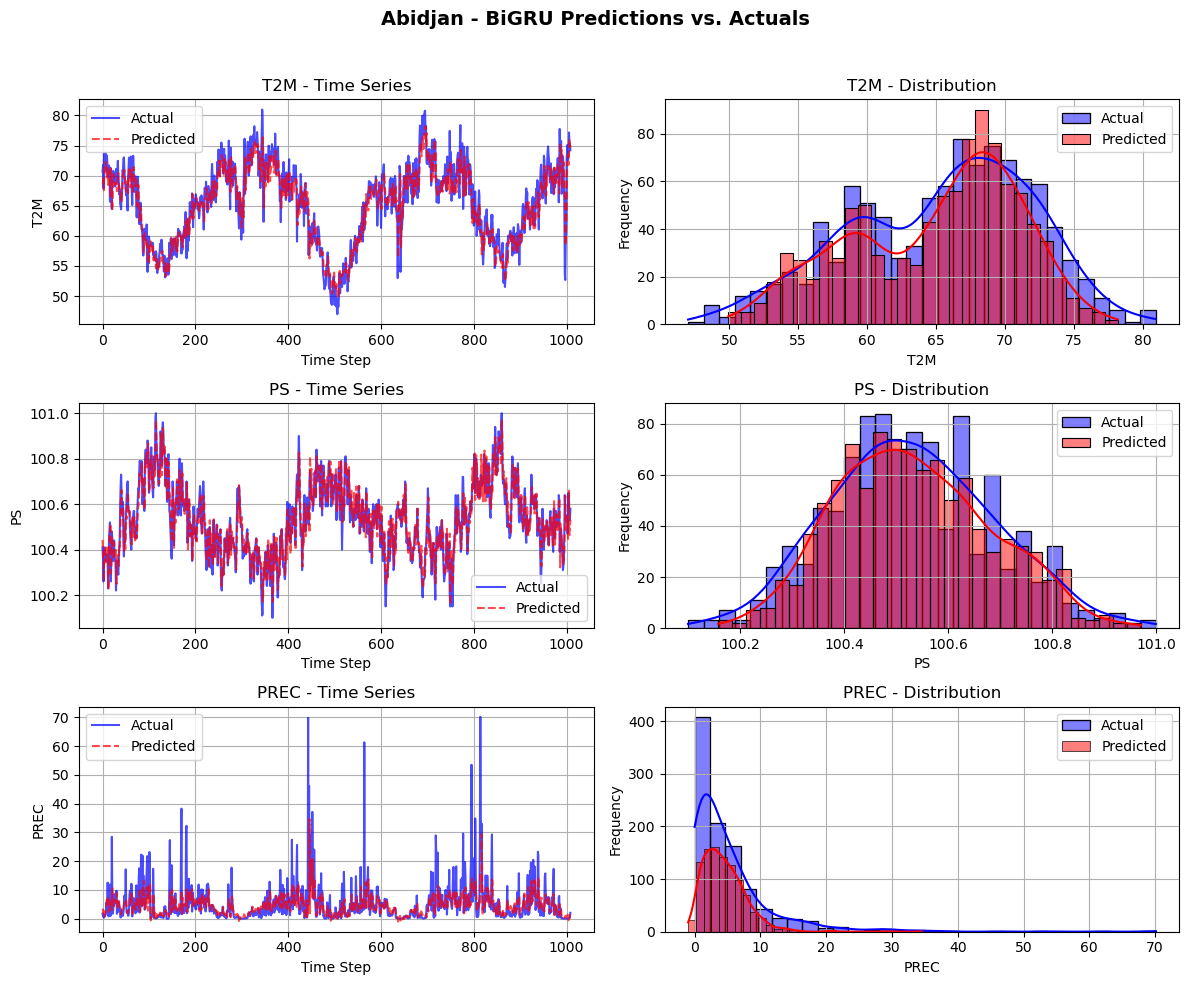

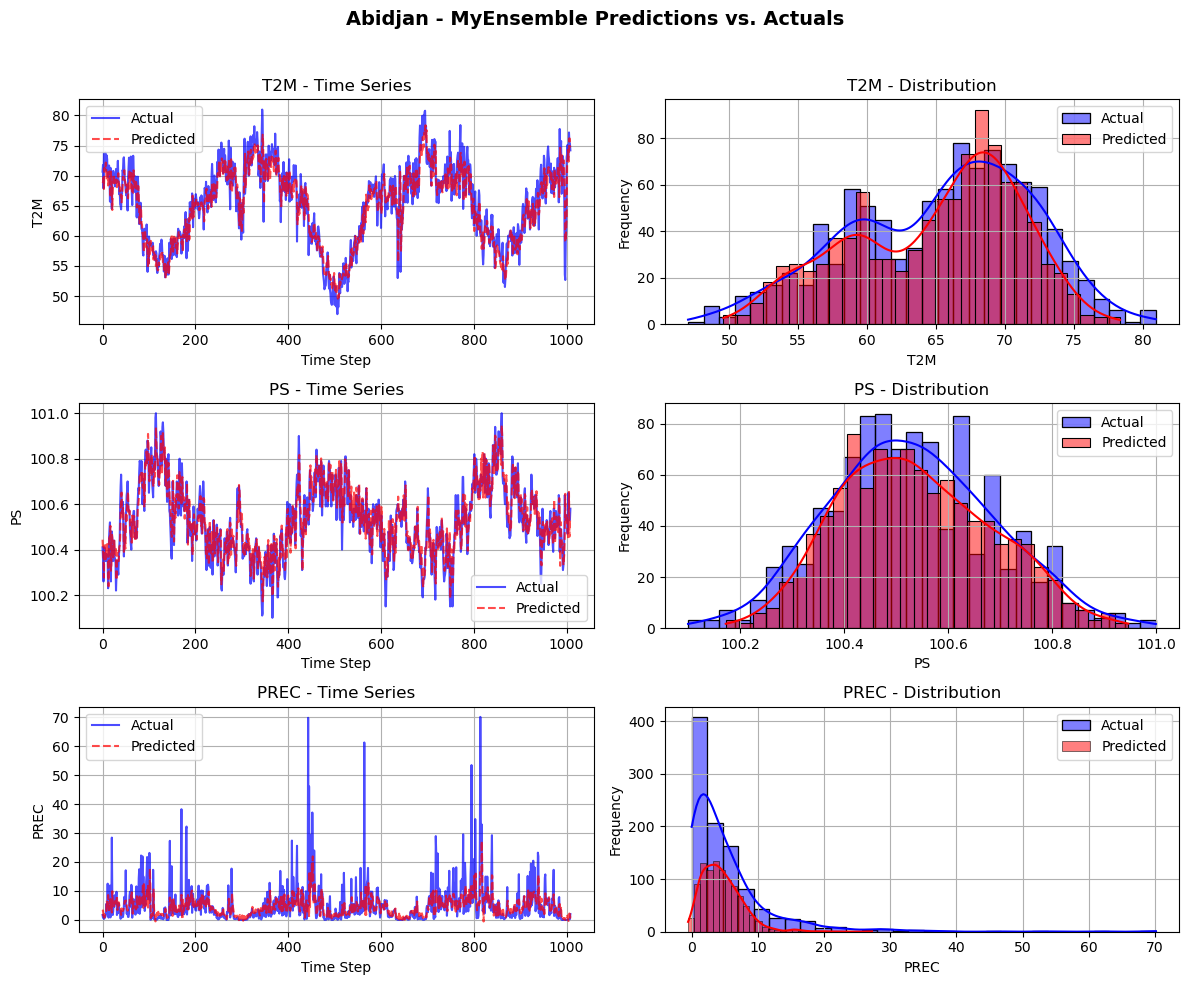

City       Model Variable      MSE    RMSE     MAE      R²      MAPE
0    Kigali   LSTMModel      T2M  12.4869  3.5337  2.7118  0.7416    4.0670
1    Kigali   LSTMModel       PS   0.0024  0.0491  0.0385  0.8593    0.0459
2    Kigali   LSTMModel     PREC  29.4953  5.4310  3.0459  0.2145  842.8203
3    Kigali    GRUModel      T2M  12.0403  3.4699  2.6750  0.7509    3.9882
4    Kigali    GRUModel       PS   0.0025  0.0496  0.0390  0.8564    0.0464
5    Kigali    GRUModel     PREC  29.4448  5.4263  3.1399  0.2158  902.8840
6    Kigali      BiLSTM      T2M  11.8499  3.4424  2.6935  0.7548    3.9444
7    Kigali      BiLSTM       PS   0.0025  0.0498  0.0393  0.8552    0.0468
8    Kigali      BiLSTM     PREC  29.0966  5.3941  2.9134  0.2251  714.2877
9    Kigali       BiGRU      T2M  11.8098  3.4365  2.6424  0.7556    3.9065
10   Kigali       BiGRU       PS   0.0026  0.0509  0.0401  0.8484    0.0478
11   Kigali       BiGRU     PREC  29.8353  5.4622  3.0244  0.2055  823.4082
12   Kigali  MyEnsemble      T2M  11.9369  3.4550  2.6660  0.7530    3.9414
13   Kigali  MyEnsemble       PS   0.0025  0.0501  0.0395  0.8537    0.0471
14   Kigali  MyEnsemble     PREC  30.2300  5.4982  2.9092  0.1949  651.7455
15  Abidjan   LSTMModel      T2M   7.2616  2.6947  2.0520  0.8349    3.2282
16  Abidjan   LSTMModel       PS   0.0036  0.0602  0.0483  0.8539    0.0481
17  Abidjan   LSTMModel     PREC  35.9654  5.9971  3.3102  0.2625  347.9945
18  Abidjan    GRUModel      T2M   7.4861  2.7361  2.0823  0.8298    3.2665
19  Abidjan    GRUModel       PS   0.0037  0.0611  0.0492  0.8496    0.0489
20  Abidjan    GRUModel     PREC  35.6789  5.9732  3.3231  0.2683  365.2702
21  Abidjan      BiLSTM      T2M   6.3758  2.5250  1.8982  0.8550    2.9552
22  Abidjan      BiLSTM       PS   0.0037  0.0606  0.0481  0.8521    0.0478
23  Abidjan      BiLSTM     PREC  36.5676  6.0471  3.1866  0.2501  359.4971
24  Abidjan       BiGRU      T2M   6.2220  2.4944  1.9174  0.8585    2.9405
25  Abidjan       BiGRU       PS   0.0037  0.0606  0.0484  0.8520    0.0481
26  Abidjan       BiGRU     PREC  37.0915  6.0903  3.1288  0.2394  261.9967
27  Abidjan  MyEnsemble      T2M   6.2710  2.5042  1.9276  0.8574    2.9558
28  Abidjan  MyEnsemble       PS   0.0036  0.0603  0.0481  0.8534    0.0479
29  Abidjan  MyEnsemble     PREC  35.9182  5.9932  3.0776  0.2634  292.3611

In [442]:
     
evaluate_and_plot(model_container, test_loader_list, scaler_dict, device)